In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import _pickle as pickle
import random
import scipy.stats as ss

# cost features

In [2]:
startTime = datetime.now()

input_age_seq = pickle.load(open("../data/baseline/input_age_seq","rb"))
input_sex_seq = pickle.load(open("../data/baseline/input_sex_seq","rb"))

input_cost_seq = pickle.load(open("../data/baseline/input_cost_seq","rb"))
target_cost_seq = pickle.load(open("../data/baseline/target_cost_seq","rb"))

input_medical_cost_seq = pickle.load(open("../data/baseline/input_medical_cost_seq","rb"))
input_monthly_medical_cost_seq = pickle.load(open("../data/baseline/input_monthly_medical_cost_seq","rb"))

input_pharmacy_cost_seq = pickle.load(open("../data/baseline/input_pharmacy_cost_seq","rb"))
input_monthly_pharmacy_cost_seq = pickle.load(open("../data/baseline/input_monthly_pharmacy_cost_seq","rb"))

print(datetime.now() - startTime)

0:00:00.767800


In [3]:
def build_feature(seq, size):    
    X = np.zeros((len(seq), size))
    for i in range(len(seq)):
        value = seq[i]
        X[i][value] = 1
    return X

In [4]:
age_feature = build_feature([i//5 for i in input_age_seq], 4)
sex_feature = build_feature([1 if i=="M" else 0 for i in input_sex_seq], 2)

cost_feature = np.array([np.log(i+1) for i in input_cost_seq]).reshape(-1,1)
medical_cost_feature = np.array([np.log(i+1) for i in input_medical_cost_seq]).reshape(-1,1)
pharmacy_cost_feature = np.array([np.log(i+1) for i in input_pharmacy_cost_seq]).reshape(-1,1)

monthly_medical_cost_feature = np.array([[np.log(i+1) for i in y] for y in input_monthly_medical_cost_seq]).reshape(-1,12)
monthly_pharmacy_cost_feature = np.array([[np.log(i+1) for i in y] for y in input_monthly_pharmacy_cost_seq]).reshape(-1,12)

In [5]:
features = [age_feature, sex_feature, cost_feature, medical_cost_feature, pharmacy_cost_feature]

X_cost = np.concatenate(features, axis =1)
X_cost.shape

(143102, 9)

In [6]:
y = np.array([np.log(i+1) for i in target_cost_seq])
# y = np.array([x/len(target_cost_seq) for x in ss.rankdata(target_cost_seq)])

# util sequence

In [7]:
startTime = datetime.now()

input_util_seq = pickle.load(open("../data/advance/input_util_seq","rb"))

print(datetime.now() - startTime)

0:00:03.343135


In [8]:
vocab = {}
for p in input_util_seq:
    for v in p:
        for c in v:
            if c not in vocab: vocab[c] = len(vocab)

In [9]:
def build_seq_feature(seq, vocab):
    X = np.zeros((len(seq),12, len(vocab) ))
    for i in range(len(seq)):
        for j in range(12):
            for value in seq[i][j]:
                X[i][j][vocab[value]] +=1
    return X

In [10]:
X_util = build_seq_feature(input_util_seq, vocab)

In [11]:
X_util = np.concatenate((monthly_medical_cost_feature.reshape(-1,12,1),\
                         monthly_pharmacy_cost_feature.reshape(-1,12,1),\
                         X_util), axis=-1)

In [12]:
X_util.shape

(143102, 12, 38)

# code sequence

In [13]:
startTime = datetime.now()

input_diag_seq = pickle.load(open("../data/advance/input_diag_seq","rb"))
input_proc_seq = pickle.load(open("../data/advance/input_proc_seq","rb"))
input_drug_seq = pickle.load(open("../data/advance/input_drug_seq","rb"))

print(datetime.now() - startTime)

0:00:06.994186


In [17]:
code2int = {"PAD":0}

code_seq = []
for p_diag, p_proc, p_drug in zip(input_diag_seq, input_proc_seq, input_drug_seq):
    new_p = []
    for diag, proc, drug in zip(p_diag, p_proc, p_drug):
        new_v = []
        for d in diag:
            if d not in code2int: code2int[d] = len(code2int)
            new_v.append(code2int[d])
        for p in proc:
            if p not in code2int: code2int[p] = len(code2int)
            new_v.append(code2int[p])
        for dr in drug:
            if dr not in code2int: code2int[dr] = len(code2int)
            new_v.append(code2int[dr])
        new_p.append(new_v)
    code_seq.append(new_p)
    
len(code2int)

10918

In [15]:
def build_seq(seq, max_codes = 50, max_length=12):
    X = np.zeros((len(seq), max_length, max_codes))
    for i, p in enumerate(seq):
        assert len(p) == max_length
        for j, claim in enumerate(p):
            claim = claim[:max_codes]
            X[i][j][:len(claim)] = claim
    return X

In [16]:
X_code = build_seq(code_seq)
X_code.shape

(143102, 12, 50)

# Model

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer

In [21]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(name='{}_W'.format(self.name),
                                 shape=(input_shape[-1],),
                                 initializer=self.init,
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(name='{}_b'.format(self.name),
                                     shape=(input_shape[1],),
                                     initializer='zero',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        e = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))  # e = K.dot(x, self.W)
        if self.bias:
            e += self.b
        e = K.tanh(e)

        a = K.exp(e)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)

        c = K.sum(a * x, axis=1)
        return c, a

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim
    

In [22]:
def build_model(max_len =12,
                max_code=50,
                max_util=38,
                max_demo=9,
                feature_code=len(code2int),
                embed_dim = 50,
                lstm_units=32,
               ):
    
    input_code = layers.Input(shape=(max_len, max_code))
    input_util = layers.Input(shape=(max_len, max_util))
    input_demo = layers.Input(shape=(max_demo,))
    inputs_list = [input_code, input_util, input_demo]
    
    # code
    tmp_input = layers.Input(shape=(max_code, ))
    tmp = layers.Embedding(input_dim=feature_code, output_dim=embed_dim, 
                           mask_zero=True, name='code_embedding')(tmp_input)
    
    tmp = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(tmp)
    tmp, ait = Attention(max_code)(tmp)
    codeEncoder = keras.models.Model(tmp_input, tmp)    
    
    input_code = layers.TimeDistributed(codeEncoder)(input_code)
    input_code = layers.Bidirectional(layers.GRU(lstm_units, return_sequences=True))(input_code)
    input_code, ait2 = Attention(max_len)(input_code)
        
    # util
    input_util = layers.Dense(lstm_units, activation="relu")(input_util)
    
    input_util = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(input_util)
    input_util, ait3 = Attention(max_len)(input_util)
    
    # demo
    out = layers.concatenate([input_code, input_util, input_demo])
    
    out = layers.Dense(lstm_units, activation="relu")(out)
    out = layers.Dropout(0.5)(out)

    out = layers.Dense(lstm_units, activation="relu")(out)
    out = layers.Dropout(0.5)(out)
    
    out = layers.Dense(1, activation=None, name='main_output')(out)
    model = keras.models.Model(inputs=inputs_list, outputs=[out])

    model.compile(optimizer='adam', loss="mse")
    print(model.summary())
    print(codeEncoder.summary())
    return model, codeEncoder

In [37]:
if True:
    seed = 0
    model, codeEncoder = build_model()
    idx_train, idx_val = train_test_split(range(len(y)), train_size=0.85, random_state=seed)
    idx_train, idx_test = train_test_split(range(len(idx_train)), train_size=0.82, random_state=seed)

    earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='min', restore_best_weights=True)
    history = model.fit([X_code[idx_train], X_util[idx_train], X_cost[idx_train]], y[idx_train], epochs=50, batch_size=100, \
                        validation_data=([X_code[idx_val], X_util[idx_val], X_cost[idx_val]], y[idx_val]), verbose=1, callbacks=[earlyStopping])
    

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 12, 50)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 12, 38)]     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 12, 64)       567262      input_5[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 12, 32)       1248        input_6[0][0]                    
______________________________________________________________________________________

In [38]:
def result(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), \
           metrics.r2_score(y_true, y_pred),\
           np.sqrt(metrics.mean_squared_error(y_true, y_pred)),\
           scipy.stats.pearsonr(y_true, y_pred)[0]

In [39]:
y_pred = model.predict([X_code[idx_train], X_util[idx_train], X_cost[idx_train]], verbose=0).reshape(-1)
result(y[idx_train], y_pred)

(0.9595873782280601,
 0.4247873229661123,
 1.4415392695797746,
 0.6570101105376487)

In [40]:
y_pred = model.predict([X_code[idx_test], X_util[idx_test], X_cost[idx_test]], verbose=0).reshape(-1)
result(y[idx_test], y_pred)

(1.0734538543011054,
 0.3029623685858661,
 1.6168529259402005,
 0.5507927112760902)

In [53]:
from operator import itemgetter
import heapq
import matplotlib.pyplot as plt
import seaborn as sns


def code_attention(p_codes, p_attention):
    month_list = []
    for v_codes, v_att in zip(p_codes, p_attention):
        code2att = {}
        for c, att in zip(v_codes, v_att):
            if c==0.0:break
            code2att[c] = code2att.get(c, 0) + att[0]
        top5 = heapq.nlargest(3, code2att.items(), key=itemgetter(1))
        month_list.append(top5)
    return month_list


def visualization(month_list):
    vocab = {}
    for month in month_list:
        for c, att in month:
            if c not in vocab:
                vocab[c] = len(vocab)
            
    heatmap = np.zeros((12, len(vocab)))
    for i, month in enumerate(month_list):
        for c, att in month:
            heatmap[i][vocab[c]] = att
    return heatmap, vocab

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()

    im = ax.imshow(data, **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def plot_generate(k):
    attention = intermediate_layer_model1.predict([X_code[idx_test][k]])[0][1]
    
    month_list = code_attention(X_code[idx_test][k], attention)
    heat, vocab = visualization(month_list)
    
    row_labels = ["T"+str(i) for i in range(12)]
    col_labels = [str(int2code[i]).replace(".","") for i in vocab.keys()]
    heatmap(heat, row_labels=row_labels, col_labels=col_labels, cmap="YlGn", cbarlabel="attention weights")
    plt.savefig("Figure" + str(k), dpi=600)
    plt.show()

In [41]:
from keras.models import Model

layer_name1 = 'attention_3'   #names are important!
layer_name2 = 'attention_4'
layer_name3 = 'attention_5'

intermediate_layer_model1 = Model(inputs=codeEncoder.input,
                                  outputs=[codeEncoder.get_layer(layer_name1).output])

intermediate_layer_model2 = Model(inputs=model.input,
                                 outputs=[model.get_layer(layer_name2).output])

intermediate_layer_model3 = Model(inputs=model.input,
                                 outputs=[model.get_layer(layer_name3).output])

# identify high cost patients

In [61]:
high_idx = []
for i, pred in enumerate(y_pred):
    if pred>10:
        print(i, pred, y[idx_test][i])
        high_idx.append(i)

366 10.098335 10.009426950609193 22445.140000000003
1131 10.537934 10.866000201072637 51489.199999999975
1579 10.115522 9.027457857875094 11993.359999999993
2227 10.087166 9.32381368968056 23329.020000000008
5924 10.743936 10.627025713253351 49529.48000000001
7549 10.296827 10.839304795158425 43070.43000000003
10298 10.018154 10.015366973881548 34171.79000000001
15928 10.512294 10.404716373950384 19260.159999999996
16158 11.67611 10.938162739177931 44439.029999999955
17998 10.4836445 10.698256317654343 8589.01
18431 10.159397 10.244004099896413 36046.790000000015
20307 10.593317 11.464127790772595 61966.330000000016
20983 10.034981 10.42040428776026 32544.08999999999
21036 10.091591 10.822677078842991 46450.89


In [ ]:
int2code = {j:i for i,j in zip(code2int.keys(), code2int.values())}

# Patient A

In [64]:
k = 17998

np.array(input_cost_seq)[idx_test][k],\
np.array(target_cost_seq)[idx_test][k],\
np.array(input_age_seq)[idx_test][k],\
np.array(input_sex_seq)[idx_test][k],\

(8589.01, 44277.57999999999, 8, 'F')

In [67]:
np.e**10.69

43914.50699755354

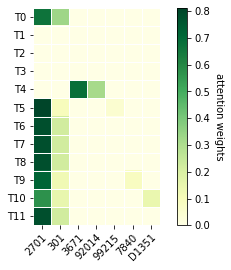

In [65]:
plot_generate(k)

# Patient B

In [68]:
k = 18431

np.array(input_cost_seq)[idx_test][k],\
np.array(target_cost_seq)[idx_test][k],\
np.array(input_age_seq)[idx_test][k],\
np.array(input_sex_seq)[idx_test][k],\

(36046.790000000015, 28112.469999999998, 13, 'F')

In [70]:
np.e**10.15, np.e**10.24

(25591.102206689688, 28001.125926231514)

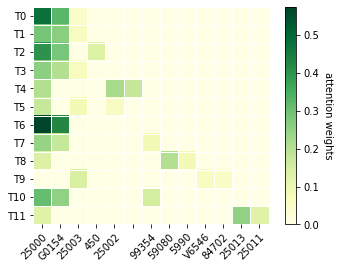

In [69]:
plot_generate(k)